In [ ]:
!pip install icecream
from icecream import ic

In [ ]:
pip install --upgrade git+https://github.com/y0ast/DUE.git


  Cloning https://github.com/y0ast/DUE.git to /tmp/pip-req-build-_2os2fff
  Running command git clone -q https://github.com/y0ast/DUE.git /tmp/pip-req-build-_2os2fff
     |████████████████████████████████| 491kB 6.4MB/s 
  Created wheel for due: filename=due-1.0-cp37-none-any.whl size=12212 sha256=5ee6a93ba395cfe5bae27fef167e3448127c7bde4058dae87b0bc9bfc8f125a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-4neadtor/wheels/bf/ce/8e/02483104d87e41ed580cf36729ba1cc1e81eacc13ea6c685d5
Successfully built due


In [ ]:
pip install git+https://github.com/pytorch/ignite


  Cloning https://github.com/pytorch/ignite to /tmp/pip-req-build-oybqxxbv
  Running command git clone -q https://github.com/pytorch/ignite /tmp/pip-req-build-oybqxxbv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pytorch-ignite: filename=pytorch_ignite-0.5.0-cp37-none-any.whl size=217687 sha256=386daa3e226ecc7e02f027c39d284dfe71ce8b3a8c53c926a6a07c57a70c9138
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ch9v_vg/wheels/92/9a/cd/39c0bc302c48329ecbe3a0d8b56678725a25332c7e9100d3b5
Successfully built pytorch-ignite


In [ ]:
import numpy as np
import torch

from ignite.engine import Events, Engine
from ignite.metrics import Average, Loss
from ignite.contrib.handlers import ProgressBar

import gpytorch
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood

from due.dkl import DKL_GP, GP, initial_values_for_GP
from due.fc_resnet import FCResNet

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette("colorblind")

In [ ]:
import numpy as np
import librosa
import librosa.display
from glob import glob
import os,sys
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import correlate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import csv
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import numpy as np
import librosa
import librosa.display
from glob import glob
import os,sys
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import correlate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import csv
from keras.models import Sequential
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics import accuracy_scoretumne #dekha hai koi
import pandas as pd
from pydrive.auth import GoogleAuth
from tensorflow import keras
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Original toy example

In [ ]:
!ls '/content/gdrive/My Drive/ME'

my_model_1.h5  my_model_2.h5  my_model.h5  PitchLabel_csv  test  Wavfile


In [ ]:
# Follows:
# https://github.com/szagoruyko/wide-residual-networks/tree/master/pytorch

import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from due.layers import spectral_norm_conv, spectral_norm_fc, SpectralBatchNorm2d


class WideBasic(nn.Module):
    def __init__(
        self,
        wrapped_conv,
        wrapped_batchnorm,
        input_size,
        in_c,
        out_c,
        stride,
        dropout_rate,
    ):
        super().__init__()
        self.bn1 = wrapped_batchnorm(in_c)
        self.conv1 = wrapped_conv(input_size, in_c, out_c, 3, stride)

        self.bn2 = wrapped_batchnorm(out_c)
        self.conv2 = wrapped_conv(input_size // stride, out_c, out_c, 3, 1)

        self.dropout_rate = dropout_rate
        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)

        if stride != 1 or in_c != out_c:
            self.shortcut = wrapped_conv(input_size, in_c, out_c, 1, stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(x))

        out = self.conv1(out)

        out = F.relu(self.bn2(out))

        if self.dropout_rate > 0:
            out = self.dropout(out)

        out = self.conv2(out)
        out += self.shortcut(x)

        return out


class WideResNet(nn.Module):
    def __init__(
        self,
        spectral_normalization,
        depth=28,
        widen_factor=10,
        num_classes=None,
        dropout_rate=0.3,
        coeff=3,
        n_power_iterations=1,
        batchnorm_momentum=0.1,
    ):
        super().__init__()

        assert (depth - 4) % 6 == 0, "Wide-resnet depth should be 6n+4"

        self.dropout_rate = dropout_rate

        def wrapped_bn(num_features):
            if spectral_normalization:
                bn = SpectralBatchNorm2d(
                    num_features, coeff, momentum=batchnorm_momentum
                )
            else:
                bn = nn.BatchNorm2d(num_features, momentum=batchnorm_momentum)

            return bn

        self.wrapped_bn = wrapped_bn

        def wrapped_conv(input_size, in_c, out_c, kernel_size, stride):
            padding = 1 if kernel_size == 3 else 0

            conv = nn.Conv2d(in_c, out_c, kernel_size, stride, padding, bias=False)

            if not spectral_normalization:
                return conv

            if kernel_size == 1:
                # use spectral norm fc, because bound are tight for 1x1 convolutions
                wrapped_conv = spectral_norm_fc(conv, coeff, n_power_iterations)
            else:
                # Otherwise use spectral norm conv, with loose bound
                input_dim = (in_c, input_size, input_size)
                wrapped_conv = spectral_norm_conv(
                    conv, coeff, input_dim, n_power_iterations
                )

            return wrapped_conv

        self.wrapped_conv = wrapped_conv

        n = (depth - 4) // 6
        k = widen_factor

        nStages = [16, 16 * k, 32 * k, 64 * k]
        strides = [1, 1, 2, 2]
        input_sizes = 32 // np.cumprod(strides)

        self.conv1 = wrapped_conv(input_sizes[0], 3, nStages[0], 3, strides[0])
        ic(self.conv1)
        self.layer1 = self._wide_layer(nStages[0:2], n, strides[1], input_sizes[1])
        ic(self.layer1)
        self.layer2 = self._wide_layer(nStages[1:3], n, strides[2], input_sizes[2])
        ic(self.layer2)
        self.layer3 = self._wide_layer(nStages[2:4], n, strides[3], input_sizes[3])
        ic(self.layer3)
        self.bn1 = self.wrapped_bn(nStages[3])
        ic(self.bn1)

        self.num_classes = num_classes
        if num_classes is not None:
            self.linear = nn.Linear(nStages[3], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                nn.init.constant_(m.bias, 0)

    def _wide_layer(self, channels, num_blocks, stride, input_size):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        in_c, out_c = channels

        for stride in strides:
            layers.append(
                WideBasic(
                    self.wrapped_conv,
                    self.wrapped_bn,
                    input_size,
                    in_c,
                    out_c,
                    stride,
                    self.dropout_rate,
                )
            )
            in_c = out_c
            input_size = input_size // stride

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.flatten(1)

        if self.num_classes is not None:
            out = self.linear(out)
            out = F.log_softmax(out, dim=1)

        return out

#import part 2

In [ ]:
def load_audio(file):
    x,sr = librosa.load(file,sr=10000,mono=True)  #merge the audio into a single channel and downsampled to 8KHz
    S = calc_spec(x,sr)
    gtv,gtf = get_pitch(file)
    gtf = np.append(gtf,np.zeros(np.shape(S)[1]-len(gtf)))
    return S,gtv,gtf

def calc_spec(x,sr):
    D = np.abs(librosa.stft(x, n_fft = Nfft, hop_length = hop_size, win_length = win_size, window='hann', dtype = np.complex256))
    D = librosa.power_to_db(D,ref=np.max)
    return D


def get_pitch(file):
    gtf = []
    gtv = []
    pathname = os.path.splitext(file)[0]
    filename = os.path.basename(pathname)
    # ff = pitch_dir + '/' + filename + '.csv'
    ff = pitch_dir + '/' + filename + '.csv'

    with open(ff,'r') as fin:
        reader = csv.reader(fin)
        for row in reader:
            gtv.append(float(row[0]))
            gtf.append(float(row[1]))
    return gtv,gtf    
    
    
def closest(arr, K):  # arr is a vector
    idx = (np.abs(arr - K)).argmin() 
    return idx,arr[idx]

def onehotlabel(pitch_range):
    values = np.asarray(pitch_range)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
#     print(integer_encoded)

    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

def getonehot(y):    
    yhot = np.zeros((len(y),len(pitch_range)))
    for i in range(len(y)):
        idx,val = closest(pitch_range,y[i]) 
#         print(idx,val,y[i])
        yhot[i,:] = onehot_pitch_range[idx,:]
    return yhot


def RPA(v,pred_Melody,pitch_labels,Nt):
    N=0
    D=0
    for i in range(Nt):
        if v[i]==1:
            if pred_Melody[i]!=0:
                N+=v[i]*Thres(M(pred_Melody[i])-M(pitch_labels[i]))
            D+=v[i]
    Raw_pitch_acc=(N/D)*100
    #print("RPA is {} %".format(Raw_pitch_acc))
    return Raw_pitch_acc

def M(f):
    f_ref=100
    return 12*np.log2(f/f_ref)

def Thres(a):
    if -0.5<a and a<0.5:
        t=1
    else:
        t=0
    return t

def Angular(a):
    x=a-12*int(a/12+0.5)
    return x

In [ ]:
model_srate = 16000
from numpy.lib.stride_tricks import as_strided
def get_activation(audio, sr, model_capacity='full', center=True, step_size=10,verbose=1):
    if len(audio.shape) == 2:
        audio = audio.mean(1)  # make mono
    audio = audio.astype(np.float32)
    if sr != model_srate:
        # resample audio if necessary
        from resampy import resample
        audio = resample(audio, sr, model_srate)

    # pad so that frames are centered around their timestamps (i.e. first frame
    # is zero centered).
    if center:
        audio = np.pad(audio, 512, mode='constant', constant_values=0)

    # make 1024-sample frames of the audio with hop length of 10 milliseconds
    hop_length = int(model_srate * step_size / 1000)
    n_frames = 1 + int((len(audio) - 1024) / hop_length)
    frames = as_strided(audio, shape=(1024, n_frames),
                        strides=(audio.itemsize, hop_length * audio.itemsize))
    frames = frames.transpose().copy()

    # normalize each frame -- this is expected by the model
    frames -= np.mean(frames, axis=1)[:, np.newaxis]
    frames /= np.std(frames, axis=1)[:, np.newaxis]

    # run prediction and convert the frequency bin weights to Hz
    return frames

In [ ]:
# audio_dir = '/home/prasad/gpytorch/DUE/MIR-1K/Wavfile'
# audio_files = glob(audio_dir + '/*.wav')
# pitch_dir = '/home/prasad/gpytorch/DUE/MIR-1K/PitchLabel_csv'
# print(len(audio_files))

In [ ]:
audio_dir = '/content/gdrive/My Drive/ME/Wavfile'
audio_files = glob(audio_dir + '/*.wav')
pitch_dir = '/content/gdrive/My Drive/ME/PitchLabel_csv'
print(len(audio_files))

1000


#Single song example

In [ ]:
# audio_dir = '/content/gdrive/My Drive/ME/Wavfile'
# audio_files = glob('*.wav')
# pitch_dir = '/content'
# print(len(audio_files))

In [ ]:
audio_files

['/content/gdrive/My Drive/ME/Wavfile/Ani_1_03.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_1_01.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_1_02.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_1_05.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_2_03.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_2_02.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_1_07.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_1_04.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_1_06.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_2_01.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_2_04.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_2_07.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_2_06.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_3_02.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_3_01.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_2_05.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_3_05.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_3_04.wav',
 '/content/gdrive/My Drive/ME/Wavfile/Ani_4_02

In [ ]:

Nfft = 1024
win_size = 1024
hop_size = 100
y,sr = librosa.load(audio_files[0],sr=16000,mono=True)
ic(y.shape)
ic(type(y))
D = np.abs(librosa.stft(y, n_fft = Nfft, hop_length = hop_size, win_length = win_size, window='hann', dtype = np.complex256))

D1 = calc_spec(y,sr)
ic(D1.shape)

ic(D.shape)
ic(type(D))

S, gtv, gtf = load_audio(audio_files[0])
ic(gtf.shape)
ic(type(gtf))


D = D[:,:len(gtf)]
ic(D.shape)
ic(type(D))
# for i in range(len(audio_files)):

ic| y.shape: (98305,)
ic| type(y): <class 'numpy.ndarray'>
ic| D1.shape: (513, 984)
ic| D.shape: (513, 984)
ic| type(D): <class 'numpy.ndarray'>
ic| gtf.shape: (615,)
ic| type(gtf): <class 'numpy.ndarray'>
ic| D.shape: (513, 615)
ic| type(D): <class 'numpy.ndarray'>


numpy.ndarray

In [ ]:
X = []
y = []
gtf_combined = []
D_combined = []

Nfft = 1024
win_size = 1024
hop_size = 100


# y,sr = librosa.load(audio_files[0],sr=16000,mono=True)
# ic(y.shape)
# ic(type(y))
# D = np.abs(librosa.stft(y, n_fft = Nfft, hop_length = hop_size, win_length = win_size, window='hann', dtype = np.complex256))
# ic(D.shape)
# ic(type(D))

# S, gtv, gtf = load_audio(audio_files[0])
# ic(gtf.shape)
# ic(type(gtf))


# D = D[:,:len(gtf)]
# ic(D.shape)
# ic(type(D))
# # for i in range(len(audio_files)):

for i in range(50):#len(audio_files)):
    if i%2==0:
      continue
    print(i)
    # print(audio_files[i])
    S, gtv, gtf = load_audio(audio_files[i])
    gtf_midi = [librosa.hz_to_midi(x) if x!=float(0) else float(0) for x in gtf]
    y,sr = librosa.load(audio_files[i],sr=16000,mono=True)
    D = np.abs(librosa.stft(y, n_fft = Nfft, hop_length = hop_size, win_length = win_size, window='hann', dtype = np.complex256))
    D = calc_spec(y,sr)
    D = D[:,:len(gtf)]
    D1 = np.matrix(D).T
    D1 = np.array(D1).astype('float64')
    # D_combined = np.hstack((D_combined,D1))
    D_combined.append(D1)
    gtf_combined = np.hstack((gtf_combined,gtf))
    # y.append(getonehot(gtf_midi))
#     print(len(X))

D_combined = np.vstack(D_combined)
# y = np.vstack(y)
# print(np.shape(X),np.shape(y))
ic(np.shape(gtf_combined))
ic(D_combined.shape)
# D_combined = np.matrix(D_combined).T
# D_combined= np.array(D_combined).astype('float64')
# ic(D_combined.shape)


1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49


ic| np.shape(gtf_combined): (20463,)
ic| D_combined.shape: (20463, 513)


(20463, 513)

In [ ]:
D_combined

array([[-19.72765982, -22.68534655, -22.49572645, ..., -39.62480081,
        -41.70493345, -31.77176367],
       [-19.7974948 , -22.71120633, -22.93410921, ..., -34.94295576,
        -34.53658957, -31.95053328],
       [-19.35191601, -23.5936999 , -22.95568149, ..., -32.53575695,
        -32.75912778, -31.97224829],
       ...,
       [-22.01174572, -22.32364649, -23.10060898, ..., -32.85896874,
        -31.95666969, -30.47582054],
       [-22.29652823, -22.90895409, -22.19786527, ..., -33.09526754,
        -31.88824322, -31.14797384],
       [-23.48173442, -24.07052743, -22.89579182, ..., -35.17957179,
        -32.34053564, -32.75728066]])

In [ ]:
D_combined.shape

(20463, 513)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
D_combined1 = (scaler.fit(D_combined))
D_combined1 = scaler.transform(D_combined)

In [ ]:
D_combined = D_combined1

In [ ]:
D1 = np.matrix(D).T
D1 = np.array(D1)
D1 = D1.astype('float64')
D1.shape


(693, 513)

In [ ]:
X = []
y = []
gtf_combined = []

Nfft = 1024
win_size = 1024
hop_size = 100

note_res = 1
pitch_range = np.arange(30, 98 + 1.0/note_res, 1.0/note_res)
pitch_range = np.concatenate([np.zeros(1), pitch_range])
print(len(pitch_range))
onehot_pitch_range = onehotlabel(pitch_range)  #one hot encoded values of MIDI numbers from 40 to 95


# for i in range(len(audio_files)):

for i in range(50):#len(audio_files)):
    if i%2==0:
      continue
    print(i)
    print(audio_files[i])
    S, gtv, gtf = load_audio(audio_files[i])
    gtf_midi = [librosa.hz_to_midi(x) if x!=float(0) else float(0) for x in gtf]
    # X.append(S.T)
    gtf_combined = np.hstack((gtf_combined,gtf))
    y.append(getonehot(gtf_midi))
#     print(len(X))
# X = np.vstack(X)
y = np.vstack(y)
print(np.shape(X),np.shape(y))
ic(np.shape(gtf_combined))

70
1
/content/gdrive/My Drive/ME/Wavfile/Ani_1_01.wav
3
/content/gdrive/My Drive/ME/Wavfile/Ani_1_05.wav
5
/content/gdrive/My Drive/ME/Wavfile/Ani_2_02.wav
7
/content/gdrive/My Drive/ME/Wavfile/Ani_1_04.wav
9
/content/gdrive/My Drive/ME/Wavfile/Ani_2_01.wav
11
/content/gdrive/My Drive/ME/Wavfile/Ani_2_07.wav
13
/content/gdrive/My Drive/ME/Wavfile/Ani_3_02.wav
15
/content/gdrive/My Drive/ME/Wavfile/Ani_2_05.wav
17
/content/gdrive/My Drive/ME/Wavfile/Ani_3_04.wav
19
/content/gdrive/My Drive/ME/Wavfile/Ani_4_03.wav
21
/content/gdrive/My Drive/ME/Wavfile/Ani_3_06.wav
23
/content/gdrive/My Drive/ME/Wavfile/Ani_4_05.wav
25
/content/gdrive/My Drive/ME/Wavfile/Ani_4_04.wav
27
/content/gdrive/My Drive/ME/Wavfile/Ani_4_07.wav
29
/content/gdrive/My Drive/ME/Wavfile/Ani_5_01.wav
31
/content/gdrive/My Drive/ME/Wavfile/Ani_5_06.wav
33
/content/gdrive/My Drive/ME/Wavfile/Ani_5_03.wav
35
/content/gdrive/My Drive/ME/Wavfile/Ani_5_04.wav
37
/content/gdrive/My Drive/ME/Wavfile/Ani_5_07.wav
39
/content/gd

ic| np.shape(gtf_combined): (20463

49
/content/gdrive/My Drive/ME/Wavfile/Kenshin_1_11.wav
(0,) (20463, 70)


,)


(20463,)

In [ ]:
#For test data
X = []
y = []
gtf_combined_test = []
D_combined_test = []

Nfft = 1024
win_size = 1024
hop_size = 100


# y,sr = librosa.load(audio_files[0],sr=16000,mono=True)
# ic(y.shape)
# ic(type(y))
# D = np.abs(librosa.stft(y, n_fft = Nfft, hop_length = hop_size, win_length = win_size, window='hann', dtype = np.complex256))
# ic(D.shape)
# ic(type(D))

# S, gtv, gtf = load_audio(audio_files[0])
# ic(gtf.shape)
# ic(type(gtf))


# D = D[:,:len(gtf)]
# ic(D.shape)
# ic(type(D))
# # for i in range(len(audio_files)):

for i in range(50):#len(audio_files)):
    if i%2==1:
      continue
    print(i)
    print(audio_files[i])
    S, gtv, gtf = load_audio(audio_files[i])
    gtf_midi = [librosa.hz_to_midi(x) if x!=float(0) else float(0) for x in gtf]
    y,sr = librosa.load(audio_files[i],sr=16000,mono=True)
    D = np.abs(librosa.stft(y, n_fft = Nfft, hop_length = hop_size, win_length = win_size, window='hann', dtype = np.complex256))
    D = calc_spec(y,sr)
    D = D[:,:len(gtf)]
    D1 = np.matrix(D).T
    D1 = np.array(D1).astype('float64')
    # D_combined = np.hstack((D_combined,D1))
    D_combined_test.append(D1)
    gtf_combined_test = np.hstack((gtf_combined_test,gtf))
    # y.append(getonehot(gtf_midi))
#     print(len(X))

D_combined_test = np.vstack(D_combined_test)
# y = np.vstack(y)
print(np.shape(X),np.shape(y))
ic(np.shape(gtf_combined_test))
ic(D_combined_test.shape)

0
/content/gdrive/My Drive/ME/Wavfile/Ani_1_03.wav
2
/content/gdrive/My Drive/ME/Wavfile/Ani_1_02.wav
4
/content/gdrive/My Drive/ME/Wavfile/Ani_2_03.wav
6
/content/gdrive/My Drive/ME/Wavfile/Ani_1_07.wav
8
/content/gdrive/My Drive/ME/Wavfile/Ani_1_06.wav
10
/content/gdrive/My Drive/ME/Wavfile/Ani_2_04.wav
12
/content/gdrive/My Drive/ME/Wavfile/Ani_2_06.wav
14
/content/gdrive/My Drive/ME/Wavfile/Ani_3_01.wav
16
/content/gdrive/My Drive/ME/Wavfile/Ani_3_05.wav
18
/content/gdrive/My Drive/ME/Wavfile/Ani_4_02.wav
20
/content/gdrive/My Drive/ME/Wavfile/Ani_4_01.wav
22
/content/gdrive/My Drive/ME/Wavfile/Ani_3_03.wav
24
/content/gdrive/My Drive/ME/Wavfile/Ani_4_08.wav
26
/content/gdrive/My Drive/ME/Wavfile/Ani_4_06.wav
28
/content/gdrive/My Drive/ME/Wavfile/Ani_4_09.wav
30
/content/gdrive/My Drive/ME/Wavfile/Ani_4_10.wav
32
/content/gdrive/My Drive/ME/Wavfile/Kenshin_1_01.wav
34
/content/gdrive/My Drive/ME/Wavfile/Ani_5_05.wav
36
/content/gdrive/My Drive/ME/Wavfile/Ani_5_08.wav
38
/content/g

ic| np.shape(gtf_combined_test): (20905,)
ic| D_combined_test.shape: (20905, 513)


(0,) (183297,)


(20905, 513)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
D_combined1_test = (scaler.fit(D_combined_test))
D_combined1_test = scaler.transform(D_combined_test)

In [ ]:
D_combined_test = D_combined1_test

In [ ]:
D_combined_test = np.matrix(D_combined_test).T
D_combined_test= np.array(D_combined_test)
D_combined_test = D_combined_test.astype('float64')
ic(D_combined_test.shape)

ic| D_combined_test.shape: (513, 20905)


(513, 20905)

In [ ]:
D_combined_test = D_combined_test.T

In [ ]:
ic(D_combined_test.shape)

ic| D_combined_test.shape: (20905, 513)


(20905, 513)

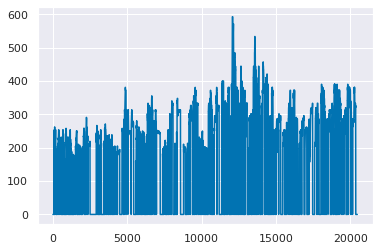

In [ ]:
plt.plot(gtf_combined)

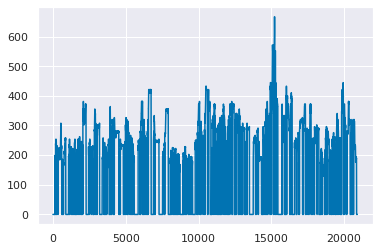

In [ ]:
plt.plot(gtf_combined_test)

In [ ]:
p=[]
for i in range (50):

  if i%2==0:
    continue
# for i in range(len(audio_files)):

  # print(i)
  b,c=librosa.load(audio_files[i])
  f=get_activation(b,c)
  # print(f.shape)
  p.append(f)
# z=np.zeros([1,1024])
# np.shape(z)
# p.append(z)
p=np.vstack(p)
np.shape(p)

(20463, 1024)

In [ ]:
ic(p.shape)
# ic(p_test.shape)
ic(gtf_combined.shape)

ic| p.shape: (20463, 1024)
ic| gtf_combined.shape: (20463,)


(20463,)

In [ ]:
# p1 = p[:20290,:]
# gtf1 = gtf_combined[:20290]
# ic(p1.shape)
# ic(gtf1.shape)


In [ ]:
D_combined

array([[ 4.45147378e-01, -3.21188335e-01, -5.16057832e-01, ...,
        -1.30670263e+00, -1.67188981e+00,  3.66101366e-01],
       [ 4.35174727e-01, -3.25863234e-01, -5.84806175e-01, ...,
        -4.23854504e-01, -3.31455714e-01,  3.38474200e-01],
       [ 4.98804758e-01, -4.85399321e-01, -5.88189198e-01, ...,
         3.00671699e-02,  9.18182089e-04,  3.35118349e-01],
       ...,
       [ 1.18972837e-01, -2.55800648e-01, -6.10917111e-01, ...,
        -3.08803661e-02,  1.50972672e-01,  5.66377217e-01],
       [ 7.83050120e-02, -3.61611828e-01, -4.69346454e-01, ...,
        -7.54388564e-02,  1.63767982e-01,  4.62502231e-01],
       [-9.09461031e-02, -5.71599610e-01, -5.78797141e-01, ...,
        -4.68472815e-01,  7.91922141e-02,  2.13798961e-01]])

In [ ]:
# import torch
# import torchvision
# import torchvision.transforms as transforms


# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# batch_size = 4

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)
# dl_train = trainloader
# dl_test = testloader

#Model

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

# input_dim = 2
batch_size = 64

# X_train, y_train = make_data()
X_train, y_train =D_combined_32,gtf_combined #combined,gtf_combined#
X_test, y_test = D_combined_32,gtf_combined #D_combined_test,gtf_combined_test #p,gtf_combined #gtf_test, p_test
domain = 15

input_dim = X_train.shape[1] #Prasad

ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=64, shuffle=False) #org 200


n_inducing_points = 20

features = 128
depth =  4
kernel = "Matern12"
kernel = "RBF"

spectral_normalization = False
num_outputs = 1 # regression with 1D output

coeff = 0.95
n_power_iterations = 1
dropout_rate = 0.0

feature_extractor = FCResNet(
    input_dim=input_dim, 
    features=features, 
    depth=depth, 
    spectral_normalization=spectral_normalization, 
    coeff=coeff, 
    n_power_iterations=n_power_iterations,
    dropout_rate=dropout_rate
)

feature_extractor = WideResNet(

    spectral_normalization=spectral_normalization, 

)

# WideResNet
#     def __init__(
#         self,
#         spectral_normalization,
#         depth=28,
#         widen_factor=10,
#         num_classes=None,
#         dropout_rate=0.3,
#         coeff=3,
#         n_power_iterations=1,
#         batchnorm_momentum=0.1,
#     ):

initial_inducing_points, initial_lengthscale = initial_values_for_GP(
        ds_train, feature_extractor, n_inducing_points
)

gp = GP(
    num_outputs=num_outputs,
    initial_lengthscale=initial_lengthscale,
    initial_inducing_points=initial_inducing_points,
    kernel=kernel,
)

model = DKL_GP(feature_extractor, gp)

likelihood = GaussianLikelihood()
loss_fn = VariationalELBO(likelihood, model.gp, num_data=len(ds_train))

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    
lr=1e-3

parameters = [
    {"params": model.feature_extractor.parameters(), "lr": lr},
    {"params": model.gp.parameters(), "lr": lr},
    {"params": likelihood.parameters(), "lr": lr},
]

optimizer = torch.optim.Adam(parameters, weight_decay=5e-4)
# pbar = ProgressBar()

def step(engine, batch):
    model.train()
    likelihood.train()
    
    optimizer.zero_grad()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)
    loss = - loss_fn(y_pred, y)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


def eval_step(engine, batch):
    model.eval()
    likelihood.eval()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)
            
    return y_pred, y

    
trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")
# pbar.attach(trainer)


metric = Loss(lambda y_pred, y: - loss_fn(y_pred, y))
metric.attach(evaluator, "loss")

@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    evaluator.run(dl_test)
    metrics = evaluator.state.metrics
    train_likelihood = trainer.state.metrics["loss"]
    if trainer.state.epoch % 20 == 0:
        print(f"Test Results - Epoch: {trainer.state.epoch} "
              f"Test Likelihood: {metrics['loss']:.2f} "
              f"Train Likelihood: {train_likelihood:.2f}")

In [ ]:
trainer.run(dl_train, max_epochs=100)

Test Results - Epoch: 20 Test Likelihood: 4677.76 Train Likelihood: 4856.66
Test Results - Epoch: 40 Test Likelihood: 1434.66 Train Likelihood: 1463.95
Test Results - Epoch: 60 Test Likelihood: 207.71 Train Likelihood: 250.81
Test Results - Epoch: 80 Test Likelihood: 42.85 Train Likelihood: 66.05
Test Results - Epoch: 100 Test Likelihood: 18.07 Train Likelihood: 28.33


State:
	iteration: 31900
	epoch: 100
	epoch_length: 319
	max_epochs: 100
	max_iters: <class 'NoneType'>
	output: 30.452558517456055
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
print(model)

DKL_GP(
  (feature_extractor): WideResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (layer1): Sequential(
      (0): WideBasic(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (dropout): Dropout(p=0.3, inplace=False)
        (shortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): WideBasic(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
# domain = 1000
# grid = 20463


In [ ]:
# x_lin = np.linspace(-domain, domain, grid)
# r_a = np.repeat(x_lin, repeats=1024, axis=0)
# r_a = r_a.reshape(grid, X_train.shape[1])
# r_a.shape

In [ ]:
# xx = torch.tensor(r_a[..., None]).float()
xx = torch.tensor(p[..., None]).float()

xx = xx.reshape(X_train.shape[0],X_train.shape[1])
xx.shape

RuntimeError: ignored

In [ ]:
xx = torch.tensor(D_combined_32[..., None]).float()

xx = xx.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3])
xx.shape

torch.Size([20463, 3, 16, 16])

In [ ]:
# xx = 20*xx

In [ ]:
xx = xx[:1000,]
xx.shape

torch.Size([1000, 3, 16, 16])

In [ ]:
model.eval()
likelihood.eval()

domain = 1
grid = 1000
x_lin = np.linspace(-domain, domain, grid)
            
with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
    # xx = torch.tensor(x_lin[..., None]).float()
    # xx = torch.tensor([x_lin[..., None],x_lin[..., None]]).float()
    # xx.reshape(100,2)
    # xx = torch.reshape(xx, (100, 2))
    # xx = torch.reshape(xx, (100, X_train.shape[1] )) #Prasad
    
    ic(xx.shape)
    if torch.cuda.is_available():
        print('Cuda')
        xx = xx.cuda()
    
    ol = likelihood(model(xx))
    output = ol.mean.cpu()
    output_std = ol.stddev.cpu()

ic| xx.shape: torch.Size([1000, 3, 16, 16])


Cuda


In [ ]:
output.shape

torch.Size([1000])

In [ ]:
output

tensor([ 11.4258,  11.4258,  11.4258,  11.4258,  11.4258,  11.4258,  11.4258,
         11.4258,  11.4258,  11.4258,  11.4258,  11.4258,  11.4258,  11.4258,
         11.4258,  11.4213,  11.4205,  11.4199,  11.4361,  11.4202,  11.4175,
         11.4170,  11.4171,  11.4169,  11.4168,  11.4169,  11.4169,  11.4169,
         11.4169,  11.4169,  11.4172,  11.4171,  11.4169,  11.4169,  11.4170,
         11.4170,  11.4169,  11.4169,  11.4168,  11.4169,  11.4169,  11.4170,
         11.4177,  11.4193,  11.4186,  11.4183,  11.4176,  11.4173,  11.4175,
         11.4177,  11.4178,  11.4174,  11.4172,  11.4169,  11.4170,  11.4169,
         11.4171,  11.4177,  11.4199,  11.4176,  11.4175,  11.4176,  11.4238,
         11.4212,  11.4191,  11.4288,  11.6124,  11.8910,  12.2065,  20.5699,
        109.1783, 174.6412, 204.9777, 207.1642, 204.2336, 190.4345, 167.9614,
        182.5677, 191.1567, 200.3735, 207.4149, 231.9095, 241.2094, 245.5835,
        253.6116, 260.4028, 259.6135, 254.5225, 270.7752, 276.98

In [ ]:
import pandas as pd
df = pd.DataFrame(output_std)
df.describe()

,0
count,1000.000000
mean,5.612563
std,0.655453
min,4.788022
25%,5.008750
50%,5.237503
75%,6.379984
max,6.379984


In [ ]:
output_std

tensor([6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3799, 6.3725, 5.8571, 5.2556,
        5.1081, 5.0972, 4.9918, 5.0395, 5.2464, 5.0640, 5.0533, 5.0863, 5.1431,
        5.1526, 5.1927, 5.2070, 5.2081, 5.2187, 5.2722, 5.2990, 5.2762, 5.2734,
        5.2888, 5.2617, 5.1795, 5.2229, 5.2316, 5.2539, 5.2443, 5.2136, 5.1708,
        5.1489, 5.0862, 5.0540, 5.0217, 5.7125, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 

In [ ]:
np.std(np.array(output_std))

0.65512604

In [ ]:
np.corrcoef(output,gtf_combined[:1000])

array([[1.        , 0.98150705],
       [0.98150705, 1.        ]])

#Train results
corr for 1000 samples - 0.98150705
MSE = 21.97760003155167


In [ ]:
plt.scatter(output,gtf_combined[:1000])

NameError: ignored

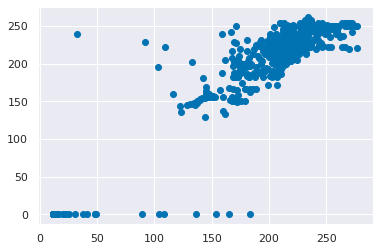

In [ ]:
plt.scatter(output,gtf_combined[:1000])

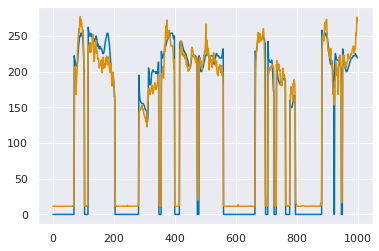

In [ ]:
plt.plot(gtf_combined[:1000])
plt.plot(output)


In [ ]:
avg_std  =np.mean((output_std).numpy())

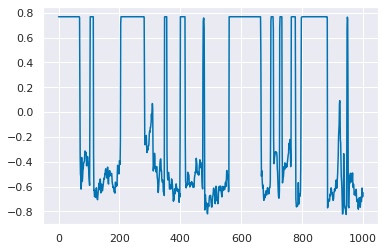

In [ ]:
plt.plot(output_std-avg_std)

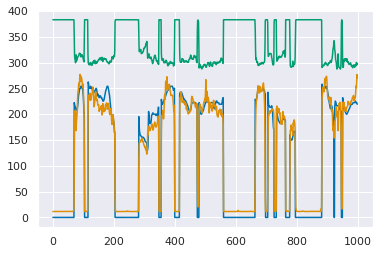

In [ ]:
plt.plot(gtf_combined[:1000])
plt.plot(output)
plt.plot(60*(output_std))

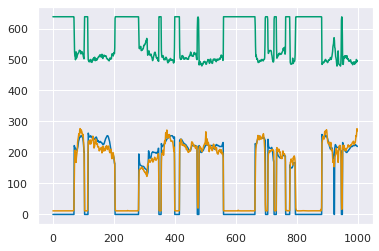

In [ ]:
plt.plot(gtf_combined[:1000])
plt.plot(output)
plt.plot((100*output_std))

torch.Size([20905, 513])

In [ ]:
np.corrcoef(output,gtf_combined_test)

array([[1.        , 0.11172415],
       [0.11172415, 1.        ]])

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(gtf_combined[:1000],output, squared=False)

21.97760003155167

#Test *results*

In [ ]:
xx1 = torch.tensor(D_combined_32_test[..., None]).float()

xx1 = xx1.reshape(xx1.shape[0],xx1.shape[1],xx1.shape[2],xx1.shape[3])
xx1.shape

torch.Size([20905, 3, 16, 16])

In [ ]:
xx1 = xx1[:1000]
xx1.shape

torch.Size([1000, 3, 16, 16])

In [ ]:
model.eval()
likelihood.eval()

domain = 1
grid = 1000
x_lin = np.linspace(-domain, domain, grid)
            
with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
    # xx = torch.tensor(x_lin[..., None]).float()
    # xx = torch.tensor([x_lin[..., None],x_lin[..., None]]).float()
    # xx.reshape(100,2)
    # xx = torch.reshape(xx, (100, 2))
    # xx = torch.reshape(xx, (100, X_train.shape[1] )) #Prasad
    
    # ic(xx.shape)
    if torch.cuda.is_available():
        print('Cuda')
        xx1 = xx1.cuda()
    
    ol1 = likelihood(model(xx1))
    output_test = ol1.mean.cpu()
    output_std_test = ol1.stddev.cpu()

Cuda


In [ ]:
output_test

tensor([ 11.4258,  11.4258,  11.4258,  11.4258,  11.4258,  11.4258,  11.4258,
         11.4258,  11.4258,  11.4258,  11.4258,  11.4258,  11.4258,  11.4258,
         11.4258,  11.5000,  11.4437,  11.5169,  11.4747,  11.5491,  11.5051,
         11.4746,  11.4345,  11.5029,  11.4374,  11.4290,  11.4200,  11.4229,
         11.4200,  11.4170,  11.4171,  11.4184,  11.4223,  11.4854,  32.7154,
        107.1513, 179.6931, 218.1714, 313.2652, 343.3295, 333.7867, 276.6884,
        104.3191,  88.1663,  45.0702,  25.9444,  64.9387, 127.1077,  95.7090,
         90.5890, 203.8870, 251.3361, 263.2436, 226.9897, 185.7683, 227.3125,
        111.2797,  46.6095,  94.2150,  67.8198,  35.5973, 124.9180, 266.7142,
        278.4836, 272.6478, 263.6453, 256.5808, 263.7461, 260.2957, 252.1651,
        233.3701, 238.6572, 253.2168, 255.2979, 262.0796, 263.6546, 266.3465,
        266.5164, 272.3501, 286.3444, 290.1494, 292.9649, 305.8860, 318.5653,
        330.0421, 335.8710, 357.6992, 365.2531, 368.8280, 378.24

In [ ]:
output_std_test

tensor([6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3800, 6.3462, 5.8920,
        5.1518, 5.0073, 4.8586, 4.8551, 4.8690, 4.9250, 5.9977, 6.1404, 6.3192,
        6.3592, 6.1856, 5.8273, 6.0477, 6.0047, 5.0937, 4.9973, 5.0142, 5.1529,
        5.5533, 5.3571, 6.0569, 6.3105, 6.0856, 6.2210, 6.3424, 5.9332, 4.9582,
        4.9621, 4.9496, 4.9022, 4.9354, 4.9328, 4.9609, 4.9854, 4.9822, 4.9576,
        4.9555, 4.9586, 4.9543, 4.9307, 4.9416, 4.9355, 4.9443, 4.9581, 4.9697,
        4.9439, 4.8972, 4.8644, 4.8499, 4.8310, 4.7771, 4.7938, 4.7692, 4.7018,
        4.7032, 4.7197, 4.7177, 4.6974, 4.6910, 4.7000, 4.7257, 4.7406, 4.7040,
        4.6767, 5.3216, 6.3682, 6.3734, 6.2278, 5.9982, 6.3706, 6.3797, 6.3800,
        6.3800, 6.3800, 6.3800, 6.3800, 

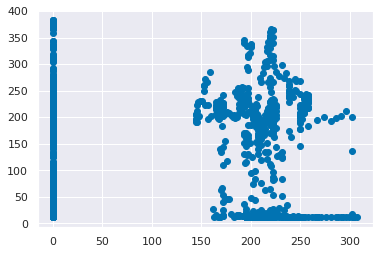

In [ ]:
plt.scatter(gtf_combined_test[:1000],output_test)

In [ ]:
# import pandas as pd
# pd.DataFrame(output).to_excel('output1.xlsx')
# pd.DataFrame(output_std).to_excel('output_std1.xlsx')
# pd.DataFrame(gtf_combined).to_excel('gtf_combined1.xlsx')


In [ ]:
np.corrcoef(gtf_combined_test[:1000],output_test)

array([[1.        , 0.10781615],
       [0.10781615, 1.        ]])

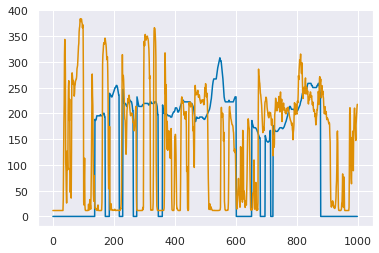

In [ ]:
plt.plot(gtf_combined_test[:1000])
plt.plot(output_test)


In [ ]:
# ic(np.rmse(gtf_combined,output))
from sklearn.metrics import mean_squared_error
mean_squared_error(gtf_combined,output, squared=False)

28.830017326984326

In [ ]:
X = []
y = []
gtf_test = []

Nfft = 1024
win_size = 1024
hop_size = 100

note_res = 1
pitch_range = np.arange(30, 98 + 1.0/note_res, 1.0/note_res)
pitch_range = np.concatenate([np.zeros(1), pitch_range])
print(len(pitch_range))
onehot_pitch_range = onehotlabel(pitch_range)  #one hot encoded values of MIDI numbers from 40 to 95



for i in range (1,50):
    if i%2==1:
      continue
  # print(i)
    print(i)
    print(audio_files[i])
    S, gtv, gtf = load_audio(audio_files[i])
    gtf_midi = [librosa.hz_to_midi(x) if x!=float(0) else float(0) for x in gtf]
    # X.append(S.T)
    gtf_test = np.hstack((gtf_test,gtf))
    y.append(getonehot(gtf_midi))
#     print(len(X))
# X = np.vstack(X)
y = np.vstack(y)
print(np.shape(X),np.shape(y))
ic(np.shape(gtf_test))

70
2
/content/gdrive/My Drive/ME/Wavfile/Ani_1_02.wav
4
/content/gdrive/My Drive/ME/Wavfile/Ani_2_03.wav
6
/content/gdrive/My Drive/ME/Wavfile/Ani_1_07.wav
8
/content/gdrive/My Drive/ME/Wavfile/Ani_1_06.wav
10
/content/gdrive/My Drive/ME/Wavfile/Ani_2_04.wav
12
/content/gdrive/My Drive/ME/Wavfile/Ani_2_06.wav
14
/content/gdrive/My Drive/ME/Wavfile/Ani_3_01.wav
16
/content/gdrive/My Drive/ME/Wavfile/Ani_3_05.wav
18
/content/gdrive/My Drive/ME/Wavfile/Ani_4_02.wav
20
/content/gdrive/My Drive/ME/Wavfile/Ani_4_01.wav
22
/content/gdrive/My Drive/ME/Wavfile/Ani_3_03.wav
24
/content/gdrive/My Drive/ME/Wavfile/Ani_4_08.wav
26
/content/gdrive/My Drive/ME/Wavfile/Ani_4_06.wav
28
/content/gdrive/My Drive/ME/Wavfile/Ani_4_09.wav
30
/content/gdrive/My Drive/ME/Wavfile/Ani_4_10.wav
32
/content/gdrive/My Drive/ME/Wavfile/Kenshin_1_01.wav
34
/content/gdrive/My Drive/ME/Wavfile/Ani_5_05.wav
36
/content/gdrive/My Drive/ME/Wavfile/Ani_5_08.wav
38
/content/gdrive/My Drive/ME/Wavfile/Ani_5_02.wav
40
/conte

ic| np.shape(gtf_test): (20290,)


(0,) (20290, 70)


(20290,)

In [ ]:
p_test=[]
# for i in range (31,50):
# for i in range(len(audio_files)):
for i in range (1,50):
  if i%2==1:
    continue
  # print(i)
  b,c=librosa.load(audio_files[i])
  f=get_activation(b,c)
  # print(f.shape)
  p_test.append(f)
# z=np.zeros([1,1024])
# np.shape(z)
# p.append(z)
p_test=np.vstack(p_test)
np.shape(p_test)

(20290, 1024)

In [ ]:
X = []
y = []
gtf_test = []

Nfft = 1024
win_size = 1024
hop_size = 100

note_res = 1
pitch_range = np.arange(30, 98 + 1.0/note_res, 1.0/note_res)
pitch_range = np.concatenate([np.zeros(1), pitch_range])
print(len(pitch_range))
onehot_pitch_range = onehotlabel(pitch_range)  #one hot encoded values of MIDI numbers from 40 to 95



for i in range (1,50):
    if i%2==1:
      continue
  # print(i)
    # print(i)
    # print(audio_files[i])
    S, gtv, gtf = load_audio(audio_files[i])
    gtf_midi = [librosa.hz_to_midi(x) if x!=float(0) else float(0) for x in gtf]
    # X.append(S.T)
    gtf_test = np.hstack((gtf_test,gtf))
    y.append(getonehot(gtf_midi))
#     print(len(X))
# X = np.vstack(X)
y = np.vstack(y)
print(np.shape(X),np.shape(y))
ic(np.shape(gtf_test))

70
2
/content/gdrive/My Drive/ME/Wavfile/Ani_1_02.wav
4
/content/gdrive/My Drive/ME/Wavfile/Ani_2_03.wav
6
/content/gdrive/My Drive/ME/Wavfile/Ani_1_07.wav
8
/content/gdrive/My Drive/ME/Wavfile/Ani_1_06.wav
10
/content/gdrive/My Drive/ME/Wavfile/Ani_2_04.wav
12
/content/gdrive/My Drive/ME/Wavfile/Ani_2_06.wav
14
/content/gdrive/My Drive/ME/Wavfile/Ani_3_01.wav
16
/content/gdrive/My Drive/ME/Wavfile/Ani_3_05.wav
18
/content/gdrive/My Drive/ME/Wavfile/Ani_4_02.wav
20
/content/gdrive/My Drive/ME/Wavfile/Ani_4_01.wav
22
/content/gdrive/My Drive/ME/Wavfile/Ani_3_03.wav
24
/content/gdrive/My Drive/ME/Wavfile/Ani_4_08.wav
26
/content/gdrive/My Drive/ME/Wavfile/Ani_4_06.wav
28
/content/gdrive/My Drive/ME/Wavfile/Ani_4_09.wav
30
/content/gdrive/My Drive/ME/Wavfile/Ani_4_10.wav
32
/content/gdrive/My Drive/ME/Wavfile/Kenshin_1_01.wav
34
/content/gdrive/My Drive/ME/Wavfile/Ani_5_05.wav
36
/content/gdrive/My Drive/ME/Wavfile/Ani_5_08.wav
38
/content/gdrive/My Drive/ME/Wavfile/Ani_5_02.wav
40
/conte

ic| np.shape(gtf_test): (20290,)


(0,) (20290, 70)


(20290,)

In [ ]:
p1=[]
# for i in range (50):
# for i in range(len(audio_files)):

# print(i)
b,c=librosa.load(audio_files[2])
f=get_activation(b,c)
# print(f.shape)
p1.append(f)
# z=np.zeros([1,1024])
# np.shape(z)
# p.append(z)
p1=np.vstack(p1)
np.shape(p1)

(989, 1024)

In [ ]:
# S, gtv, gtf1 = load_audio(audio_files[2])

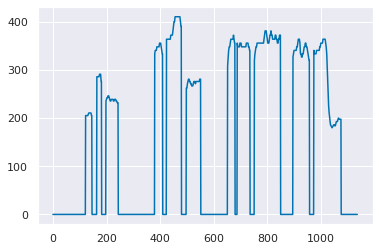

In [ ]:
plt.plot(gtf1)

In [ ]:
p1 = p_test

In [ ]:
domain = 1000
grid = 20290

In [ ]:
x_lin = np.linspace(-domain, domain, grid)
r_a = np.repeat(x_lin, repeats=1024, axis=0)
r_a = r_a.reshape(grid, X_train.shape[1])
r_a.shape

(20290, 1024)

In [ ]:

# xx = torch.tensor(r_a[..., None]).float()
xx = torch.tensor(p1[..., None]).float()

xx = xx.reshape(grid,X_train.shape[1])
xx.shape


torch.Size([20290, 1024])

In [ ]:
p1

array([[ 0.03754214,  0.03754214,  0.03754214, ..., -1.4119569 ,
        -1.6030318 , -1.7054296 ],
       [ 0.04759327,  0.04759327,  0.04759327, ..., -0.25752422,
        -0.58431756, -0.8625565 ],
       [ 0.11338631,  0.11338631,  0.11338631, ..., -0.06011994,
         0.19166441, -0.06682858],
       ...,
       [ 0.5514131 ,  0.80805206,  0.8896461 , ..., -0.01698426,
        -0.01698426, -0.01698426],
       [-1.6835531 , -1.5999187 , -1.4281274 , ...,  0.01184575,
         0.01184575,  0.01184575],
       [ 0.6773999 ,  0.58026004,  0.5133921 , ...,  0.00655166,
         0.00655166,  0.00655166]], dtype=float32)

In [ ]:
model.eval()
likelihood.eval()

domain = 1
grid = 1000
x_lin = np.linspace(-domain, domain, grid)
            
with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
    # xx = torch.tensor(x_lin[..., None]).float()
    # xx = torch.tensor([x_lin[..., None],x_lin[..., None]]).float()
    # xx.reshape(100,2)
    # xx = torch.reshape(xx, (100, 2))
    # xx = torch.reshape(xx, (100, X_train.shape[1] )) #Prasad
    
    ic(xx.shape)
    if torch.cuda.is_available():
        print('Cuda')
        xx = xx.cuda()
    
    ol = likelihood(model(xx))
    output_test = ol.mean.cpu()
    output_std_test = ol.stddev.cpu()

ic| xx.shape: torch.Size([20290, 1024])


In [ ]:
output_test

tensor([208.4778,  24.5497,  29.3786,  ..., 114.6711, 106.6138, 252.5905])

In [ ]:
output_std_test

tensor([6.1983, 6.6572, 6.6543,  ..., 6.5543, 6.5773, 6.0223])

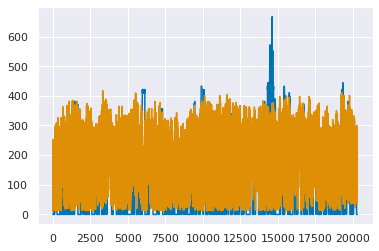

In [ ]:
plt.plot(gtf_test)
plt.plot(output_test)

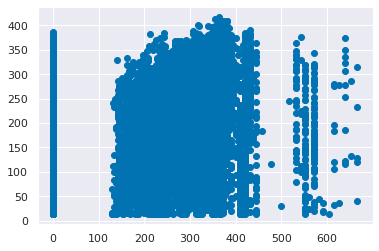

In [ ]:
plt.scatter(gtf_test,output_test)

In [ ]:
np.corrcoef(gtf_test,output_test)

array([[1.        , 0.35250795],
       [0.35250795, 1.        ]])

In [ ]:
import pandas as pd
pd.DataFrame(output).to_excel('output_test1.xlsx')
pd.DataFrame(output_std).to_excel('output_std_test1.xlsx')
pd.DataFrame(gtf_combined).to_excel('gtf_combined_test1.xlsx')


In [ ]:
#Original

# Follows:
# https://github.com/szagoruyko/wide-residual-networks/tree/master/pytorch

import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from due.layers import spectral_norm_conv, spectral_norm_fc, SpectralBatchNorm2d


class WideBasic(nn.Module):
    def __init__(
        self,
        wrapped_conv,
        wrapped_batchnorm,
        input_size,
        in_c,
        out_c,
        stride,
        dropout_rate,
    ):
        super().__init__()
        self.bn1 = wrapped_batchnorm(in_c)
        self.conv1 = wrapped_conv(input_size, in_c, out_c, 3, stride)

        self.bn2 = wrapped_batchnorm(out_c)
        self.conv2 = wrapped_conv(input_size // stride, out_c, out_c, 3, 1)

        self.dropout_rate = dropout_rate
        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)

        if stride != 1 or in_c != out_c:
            self.shortcut = wrapped_conv(input_size, in_c, out_c, 1, stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(x))

        out = self.conv1(out)

        out = F.relu(self.bn2(out))

        if self.dropout_rate > 0:
            out = self.dropout(out)

        out = self.conv2(out)
        out += self.shortcut(x)

        return out


class WideResNet(nn.Module):
    def __init__(
        self,
        spectral_normalization,
        depth=28,
        widen_factor=10,
        num_classes=None,
        dropout_rate=0.3,
        coeff=3,
        n_power_iterations=1,
        batchnorm_momentum=0.1,
    ):
        super().__init__()

        assert (depth - 4) % 6 == 0, "Wide-resnet depth should be 6n+4"

        self.dropout_rate = dropout_rate

        def wrapped_bn(num_features):
            if spectral_normalization:
                bn = SpectralBatchNorm2d(
                    num_features, coeff, momentum=batchnorm_momentum
                )
            else:
                bn = nn.BatchNorm2d(num_features, momentum=batchnorm_momentum)

            return bn

        self.wrapped_bn = wrapped_bn

        def wrapped_conv(input_size, in_c, out_c, kernel_size, stride):
            padding = 1 if kernel_size == 3 else 0

            conv = nn.Conv2d(in_c, out_c, kernel_size, stride, padding, bias=False)

            if not spectral_normalization:
                return conv

            if kernel_size == 1:
                # use spectral norm fc, because bound are tight for 1x1 convolutions
                wrapped_conv = spectral_norm_fc(conv, coeff, n_power_iterations)
            else:
                # Otherwise use spectral norm conv, with loose bound
                input_dim = (in_c, input_size, input_size)
                wrapped_conv = spectral_norm_conv(
                    conv, coeff, input_dim, n_power_iterations
                )

            return wrapped_conv

        self.wrapped_conv = wrapped_conv

        n = (depth - 4) // 6
        k = widen_factor

        nStages = [16, 16 * k, 32 * k, 64 * k]
        strides = [1, 1, 2, 2]
        input_sizes = 32 // np.cumprod(strides)

        self.conv1 = wrapped_conv(input_sizes[0], 3, nStages[0], 3, strides[0])
        self.layer1 = self._wide_layer(nStages[0:2], n, strides[1], input_sizes[1])
        self.layer2 = self._wide_layer(nStages[1:3], n, strides[2], input_sizes[2])
        self.layer3 = self._wide_layer(nStages[2:4], n, strides[3], input_sizes[3])

        self.bn1 = self.wrapped_bn(nStages[3])

        self.num_classes = num_classes
        if num_classes is not None:
            self.linear = nn.Linear(nStages[3], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                nn.init.constant_(m.bias, 0)

    def _wide_layer(self, channels, num_blocks, stride, input_size):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        in_c, out_c = channels

        for stride in strides:
            layers.append(
                WideBasic(
                    self.wrapped_conv,
                    self.wrapped_bn,
                    input_size,
                    in_c,
                    out_c,
                    stride,
                    self.dropout_rate,
                )
            )
            in_c = out_c
            input_size = input_size // stride

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.flatten(1)

        if self.num_classes is not None:
            out = self.linear(out)
            out = F.log_softmax(out, dim=1)

        return out

In [ ]:
#Modified
# Follows:
# https://github.com/szagoruyko/wide-residual-networks/tree/master/pytorch

import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from due.layers import spectral_norm_conv, spectral_norm_fc, SpectralBatchNorm2d


class WideBasic(nn.Module):
    def __init__(
        self,
        wrapped_conv,
        wrapped_batchnorm,
        input_size,
        in_c,
        out_c,
        stride,
        dropout_rate,
    ):
        super().__init__()
        self.bn1 = wrapped_batchnorm(in_c)
        self.conv1 = wrapped_conv(input_size, in_c, out_c, 3, stride)

        self.bn2 = wrapped_batchnorm(out_c)
        self.conv2 = wrapped_conv(input_size // stride, out_c, out_c, 3, 1)

        self.dropout_rate = dropout_rate
        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)

        if stride != 1 or in_c != out_c:
            self.shortcut = wrapped_conv(input_size, in_c, out_c, 1, stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(x))

        out = self.conv1(out)

        out = F.relu(self.bn2(out))

        if self.dropout_rate > 0:
            out = self.dropout(out)

        out = self.conv2(out)
        out += self.shortcut(x)

        return out


class WideResNet(nn.Module):
    def __init__(
        self,
        spectral_normalization,
        depth=28,
        widen_factor=10,
        num_classes=None,
        dropout_rate=0.3,
        coeff=3,
        n_power_iterations=1,
        batchnorm_momentum=0.1,
    ):
        super().__init__()

        assert (depth - 4) % 6 == 0, "Wide-resnet depth should be 6n+4"

        self.dropout_rate = dropout_rate

        def wrapped_bn(num_features):
            if spectral_normalization:
                bn = SpectralBatchNorm2d(
                    num_features, coeff, momentum=batchnorm_momentum
                )
            else:
                bn = nn.BatchNorm2d(num_features, momentum=batchnorm_momentum)

            return bn

        self.wrapped_bn = wrapped_bn

        def wrapped_conv(input_size, in_c, out_c, kernel_size, stride):
            padding = 1 if kernel_size == 3 else 0

            conv = nn.Conv2d(in_c, out_c, kernel_size, stride, padding, bias=False)

            if not spectral_normalization:
                return conv

            if kernel_size == 1:
                # use spectral norm fc, because bound are tight for 1x1 convolutions
                wrapped_conv = spectral_norm_fc(conv, coeff, n_power_iterations)
            else:
                # Otherwise use spectral norm conv, with loose bound
                input_dim = (in_c, input_size, input_size)
                wrapped_conv = spectral_norm_conv(
                    conv, coeff, input_dim, n_power_iterations
                )

            return wrapped_conv

        self.wrapped_conv = wrapped_conv

        n = (depth - 4) // 6
        k = widen_factor

        nStages = [16, 16 * k, 32 * k, 64 * k]
        strides = [1, 1, 2, 2]
        input_sizes = 32 // np.cumprod(strides)

        self.conv1 = wrapped_conv(input_sizes[0], 3, nStages[0], 3, strides[0])
        self.layer1 = self._wide_layer(nStages[0:2], n, strides[1], input_sizes[1])
        self.layer2 = self._wide_layer(nStages[1:3], n, strides[2], input_sizes[2])
        self.layer3 = self._wide_layer(nStages[2:4], n, strides[3], input_sizes[3])

        self.bn1 = self.wrapped_bn(nStages[3])
        self.fc = nn.Linear(nStages[3], 128)
        self.num_classes = num_classes
        if num_classes is not None:
            self.linear = nn.Linear(nStages[3], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                nn.init.constant_(m.bias, 0)

    def _wide_layer(self, channels, num_blocks, stride, input_size):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        in_c, out_c = channels

        for stride in strides:
            layers.append(
                WideBasic(
                    self.wrapped_conv,
                    self.wrapped_bn,
                    input_size,
                    in_c,
                    out_c,
                    stride,
                    self.dropout_rate,
                )
            )
            in_c = out_c
            input_size = input_size // stride

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.bn1(out)
        # out =self.fc(out)
        # out =F.relu(out)
        out = F.relu(self.bn1(out))
        # out = F.avg_pool2d(out, 8)
        out = out.flatten(1)

        if self.num_classes is not None:
            out = self.linear(out)
            out = F.log_softmax(out, dim=1)

        return out

#Test

In [ ]:
feature_extractor = WideResNet(

    spectral_normalization=spectral_normalization, 

)
feature_extractor

NameError: ignored

In [ ]:
ic(D_combined.shape,gtf_combined.shape)

ic| D_combined.shape: (20463, 513), gtf_combined.shape: (20463,)


((20463, 513), (20463,))

In [ ]:
D = []
n = 16

D_arr = np.zeros((D_combined.shape[0],n,D_combined.shape[1]))
# for i in range(int(np.floor(n/2)),int(len(D_combined)-np.floor(n/2))):
for i in range(int((n-1/2)),int(len(D_combined)-(n/2))):

  # print(i)
  # if i ==10:
  #   break
  # for j in range(-int(np.floor(i/2)),int(np.floor(i/2))):
  # row = D_combined[int(i-np.floor(n/2)):i+int(np.floor(n/2)),:]
  row = D_combined[int(i-(n/2)):i+int((n/2)),:]
  D.append(row)
  # ic(row)
  # ic(row.shape)
  D_arr[i,:,:] = row
# D_arr = np.asarray(D)
ic(D_arr.shape)

ic| D_arr.shape: (20463, 16, 513)


(20463, 16, 513)

In [ ]:
D_combined_32 = D_arr[:,:,:16]
ic(D_combined_32.shape)

ic| D_combined_32.shape: (20463, 16, 16)


(20463, 16, 16)

In [ ]:
bb = np.hstack((D_combined_32,D_combined_32))
bb.shape

(20463, 32, 16)

In [ ]:
arrs = [D_combined_32,D_combined_32,D_combined_32]

In [ ]:
res = np.array(arrs)
res.shape

(3, 20463, 16, 16)

In [ ]:

res1 =np.swapaxes(res,0,1)
res1.shape

(20463, 3, 16, 16)

In [ ]:
D_combined_32=res1

In [ ]:
D_combined_32.shape

(20463, 3, 16, 16)

In [ ]:
# For test data
# ic(np.mean(D_combined))

# ic(np.mean(D_combined_test))
D = []
n = 16

D_arr1 = np.zeros((D_combined_test.shape[0],n,D_combined_test.shape[1]))
# for i in range(int(np.floor(n/2)),int(len(D_combined)-np.floor(n/2))):
for i in range(int((n-1/2)),int(len(D_combined_test)-(n/2))):

  # print(i)
  # if i ==10:
  #   break
  # for j in range(-int(np.floor(i/2)),int(np.floor(i/2))):
  # row = D_combined[int(i-np.floor(n/2)):i+int(np.floor(n/2)),:]
  row1 = D_combined_test[int(i-(n/2)):i+int((n/2)),:]
  # D1.append(row1)
  # ic(row)
  # ic(row.shape)
  D_arr1[i,:,:] = row1
# D_arr = np.asarray(D)
ic(D_arr1.shape)

D_combined_32_test = D_arr1[:,:,:16]
ic(D_combined_32_test.shape)
arrs1 = [D_combined_32_test,D_combined_32_test,D_combined_32_test]
res_1 = np.array(arrs1)
ic(res_1.shape)
res1_1 =np.swapaxes(res_1,0,1)
ic(res1_1.shape)



ic| D_arr1.shape: (20905, 16, 513)
ic| D_combined_32_test.shape: (20905, 16, 16)
ic| res_1.shape: (3, 20905, 16, 16)
ic| res1_1.shape: (20905, 3, 16, 16)


(20905, 3, 16, 16)

In [ ]:
D_combined_32_test=res1_1
ic(D_combined_32_test.shape)


ic| D_combined_32_test.shape: (20905, 3, 16, 16)


(20905, 3, 16, 16)

In [ ]:
D_combined[-int(i+np.floor(n/2)):i+int(np.floor(n/2))]

array([], shape=(0, 513), dtype=float64)

In [ ]:
from torch.utils import data
from torchvision import datasets, transforms


def get_CIFAR10(root):
    input_size = 32
    num_classes = 10

    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

    # Alternative
    # normalize = transforms.Normalize(
    #     (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
    # )

    train_transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]
    )

    train_dataset = datasets.CIFAR10(
        root + "/CIFAR10", train=True, transform=train_transform, download=True
    )

    test_transform = transforms.Compose([transforms.ToTensor(), normalize])
    test_dataset = datasets.CIFAR10(
        root + "/CIFAR10", train=False, transform=test_transform, download=False
    )

    return input_size, num_classes, train_dataset, test_dataset

